In [2]:
!pip install casadi

In [6]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


dx = [6.001e-07, 6, 0, 0, 0.0115]
[0.010000009999986693]
0.07000004999993348
dx = [2.54033e-05, 6.001e-10, 1.95032e-06, 3.0005e-06, 0.00599999]
[0.005999991999994412]
0.1
dx = [0.00122501, 2.54033e-08, 8.45101e-05, 0.000130017, 1.99998e-09]
[2.000130024504834e-09]
0.1
dx = [0.0584943, 1.22501e-06, 0.00406575, 0.00625507, 1.99998e-09]
[2.0064810893763496e-09]
0.1
dx = [2.7931, 5.84943e-05, 0.19417, 0.298726, -0.00845064]
[-0.00845064058560548]
0.05774679550820612
dx = [73.0998, 0.0027931, 9.27164, 14.2642, -0.01]
[-0.01000000999968698]
0.00774667082817998
dx = [47.3764, 0.0730998, 246.814, 379.763, -0.000248698]
[-0.0002479851823882669]
0.006503178855962295
dx = [1.53998, 0.0473764, 399.475, 616.645, -2.0893e-06]
[1.6898860861198956e-05]
0.006492732361557107
dx = [3.03012, 0.00153998, 402.34, 624.345, -7.16379e-06]
[2.366846177596174e-05]
0.006456913410110903
dx = [3.00259, 0.00303012, 409.914, 639.496, -7.29188e-06]
[2.3925366104693486e-05]
0.006420454004738671
dx = [2.97209, 0.0030025

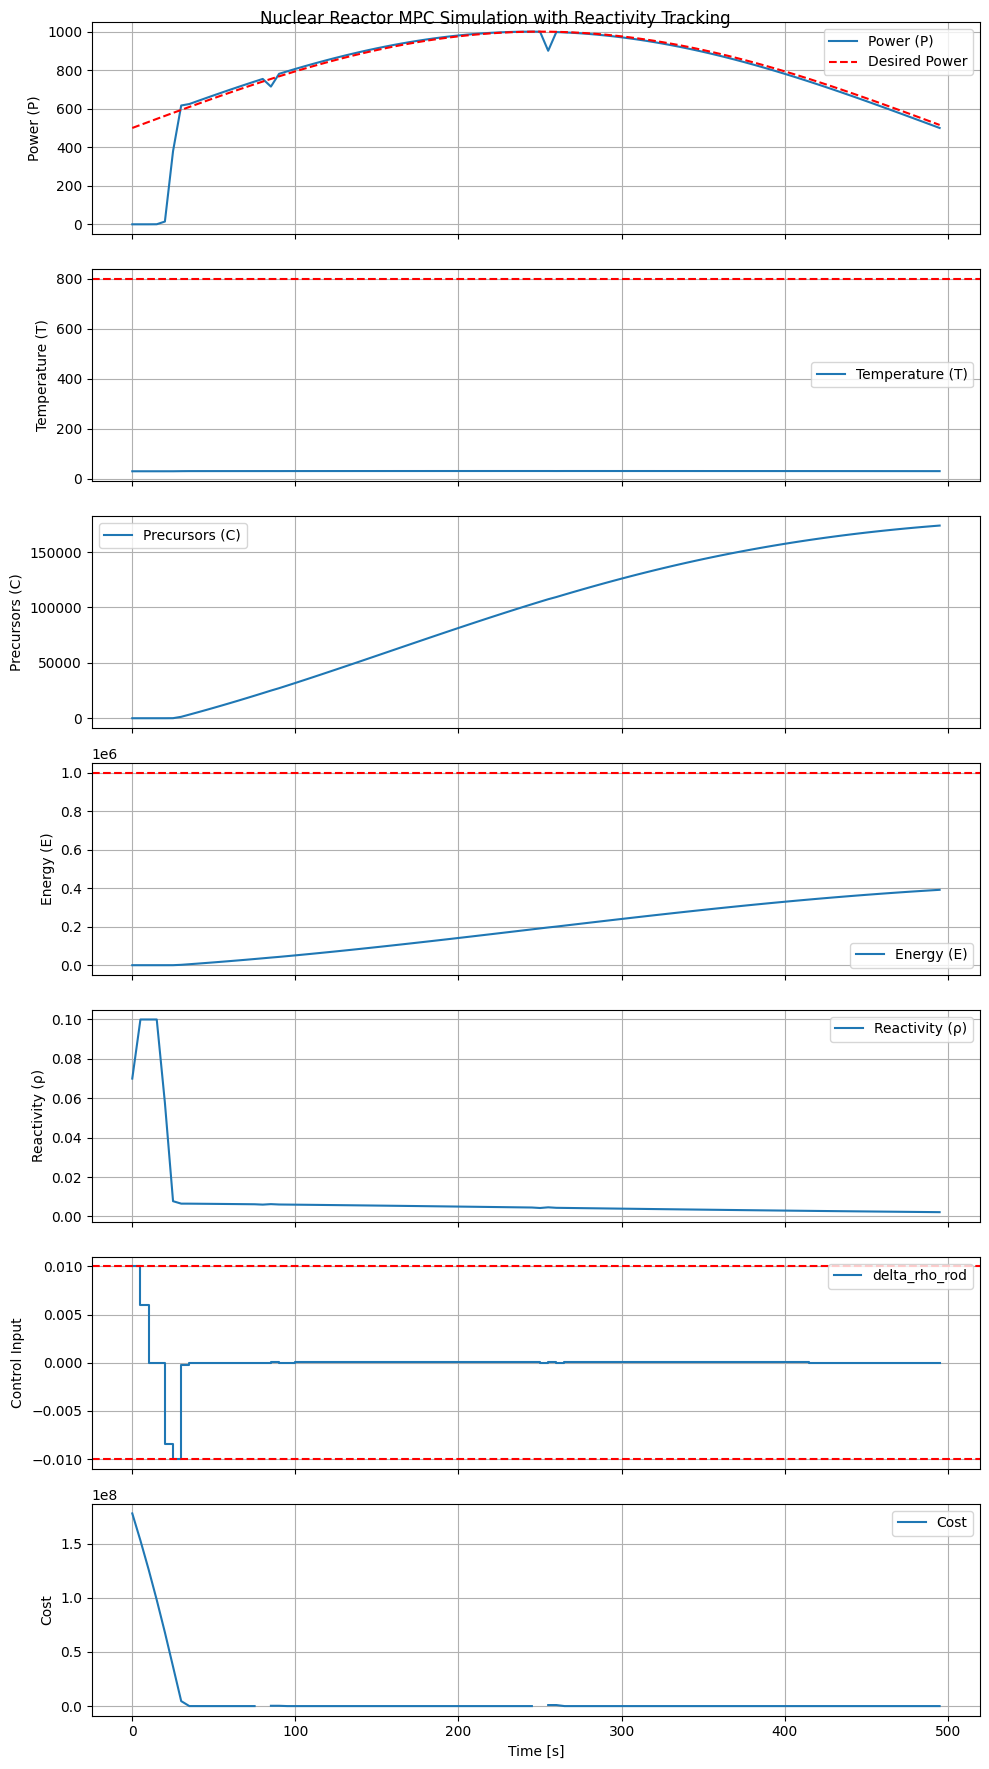

In [116]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

class Plant:
    def __init__(self, dt=0.1):
        self.dt = dt
        # State: [Power, Temperature, Precursors, Energy, Reactivity]
        self.x = np.zeros(5)  
        self.Λ = 1e-2
        self.λ = 0.0001
        self.α = -5e-5
        self.β0 = 0.0065
        self.γ = 1e-8
        self.mcp = 5000
        self.hA = 1e3
        self.T_coolant = 30
        self.T0 = 250
        self.E_max = 1e6
        self.P_max = 1e3
        self.T_max = 800.0
        self.delta_rho_rod_limit = 0.01
        self.rho_rod_limit = 0.1

    def dynamics(self, x, control):
        P = x[0]
        T = x[1]
        C = x[2]
        E = x[3]
        rho = x[4]  # Now rho is a state variable
        eps = 1e-6
        
        delta_rho_rod = control[0] / self.dt
        beta_mix = self.β0 - self.γ * E
        
        # Update rho with delta_rho_rod and temperature feedback
        delta_rho = delta_rho_rod * self.dt + self.α * (T - self.T_coolant)

        #print(f"(rho - beta_mix) / self.Λ * (P+eps) = {(rho - beta_mix) / self.Λ * (P+eps)}")
        #print(f"self.λ * (C+eps) = {self.λ * (C+eps)}")
        
        dP = (rho - beta_mix) / self.Λ * (P+eps) + self.λ * (C+eps)
        dT = P / self.mcp - (self.hA / self.mcp) * (T - self.T_coolant)
        dC = beta_mix / self.Λ * P - self.λ * C
        dE = P
        drho = delta_rho  # Change in reactivity
        
        return ca.vertcat(dP, dT, dC, dE, drho)

    def step(self, control):
        dx = self.dynamics(self.x, control)
        self.x = self.x + self.dt * np.array(dx).flatten()
        print(f"dx = {dx}")
        print(control)
        
        # Apply constraints
        #self.x[1] = min(self.x[1], self.T_max)
        self.x[2] = max(self.x[2], 0)
        #self.x[3] = min(self.x[3], self.E_max)
        self.x[4] = np.clip(self.x[4], 0, self.rho_rod_limit)
        print(self.x[4])
        
        return self.x

class MPCController:
    def __init__(self, plant, horizon=20):
        self.plant = plant
        self.horizon = horizon
        self.opti = ca.Opti()
        self.U = self.opti.variable(horizon)
        self.X = self.opti.variable(5, horizon+1)  # Now 5 states
        self.X0 = self.opti.parameter(5)
        self.P_ref = self.opti.parameter(horizon+1)

        self.opti.subject_to(self.X[:,0] == self.X0)
        self.costs = []
        total_cost = 0

        for k in range(horizon):
            xk = self.X[:,k]
            uk = self.U[k]
            dX = self.plant.dynamics(xk, [uk])
            xk1 = xk + self.plant.dt * dX
            self.opti.subject_to(self.X[:,k+1] == xk1)
            self.opti.subject_to(self.opti.bounded(-self.plant.delta_rho_rod_limit, 
                                              uk, 
                                              self.plant.delta_rho_rod_limit))
            
            self.opti.subject_to(self.opti.bounded(0, 
                                              xk1[4], 
                                              self.plant.rho_rod_limit))
            
            self.opti.subject_to(self.opti.bounded(0, 
                                              xk1[0],
                                              1e9))
            self.opti.subject_to(self.opti.bounded(0, 
                                              xk1[2],
                                              1e9))

            P_error = (self.X[0,k] - self.P_ref[k])**2
            u_cost = uk**2
            T_viol = ca.fmax(0, xk[1] - self.plant.T_max)**2

            stage_cost = 100 * P_error + 0.1 * u_cost + 1e5 * T_viol
            self.costs.append(stage_cost)
            total_cost += stage_cost

        terminal_cost = 500 * (self.X[0,horizon] - self.P_ref[horizon])**2
        total_cost += terminal_cost
        self.costs.append(terminal_cost)

        self.obj = total_cost
        self.opti.minimize(self.obj)

        opts = {"ipopt.print_level":1, "print_time":0}
        self.opti.solver('ipopt', opts)

    def compute_control(self, x0, P_ref_traj):
        self.opti.set_value(self.X0, x0)
        self.opti.set_value(self.P_ref, P_ref_traj)
        try:
            sol = self.opti.solve()
            cost_val = sol.value(self.obj)
            return float(sol.value(self.U[0])), cost_val
        except:
            return 0.0, float('inf')

class Animator:
    def __init__(self, plant, controller, time_horizon=100):
        self.plant = plant
        self.controller = controller
        self.time_horizon = time_horizon
        self.history = {'t':[], 'x':[], 'u':[], 'ref':[], 'cost':[]}

    def desired_trajectory(self, t):
        return self.plant.P_max/2 + self.plant.P_max/2 * np.sin(np.pi * t / (self.time_horizon * self.plant.dt))

    def run(self):
        for i in range(self.time_horizon):
            t_now = i * self.plant.dt
            x = self.plant.x.copy()
            ref = np.array([self.desired_trajectory(t_now + k * self.plant.dt) for k in range(self.controller.horizon + 1)])
            u, cost = self.controller.compute_control(x, ref)
            self.plant.step([u])
            self.history['t'].append(t_now)
            self.history['x'].append(self.plant.x.copy())
            self.history['u'].append(u)
            self.history['ref'].append(ref[0])
            self.history['cost'].append(cost)
        self.plot()

    def plot(self):
        t = self.history['t']
        xs = np.array(self.history['x'])
        us = np.array(self.history['u'])
        ref = np.array(self.history['ref'])
        costs = np.array(self.history['cost'])

        fig, axs = plt.subplots(7,1, figsize=(10,18), sharex=True)
        labels = ['Power (P)','Temperature (T)','Precursors (C)',
                 'Energy (E)','Reactivity (ρ)']
        
        # Plot each state variable
        for i in range(5):
            axs[i].plot(t, xs[:,i], label=labels[i])
            axs[i].grid(True)
            axs[i].legend()
            axs[i].set_ylabel(labels[i])
            if labels[i]=='Temperature (T)':
                axs[i].axhline(self.plant.T_max, color='r', linestyle='--', label='T_max')
            if labels[i]=='Energy (E)':
                axs[i].axhline(self.plant.E_max, color='r', linestyle='--', label='E_max')
        
        # Plot reference power
        axs[0].plot(t, ref, 'r--', label='Desired Power')
        axs[0].legend()

        # Plot control input
        axs[5].step(t, us, where='post', label='delta_rho_rod')
        axs[5].axhline(self.plant.delta_rho_rod_limit, color='r', linestyle='--')
        axs[5].axhline(-self.plant.delta_rho_rod_limit, color='r', linestyle='--')
        axs[5].legend()
        axs[5].set_ylabel('Control Input')
        axs[5].grid(True)

        # Plot cost
        axs[6].plot(t, costs, label='Cost')
        axs[6].set_ylabel('Cost')
        axs[6].set_xlabel('Time [s]')
        axs[6].grid(True)
        axs[6].legend()

        plt.suptitle('Nuclear Reactor MPC Simulation with Reactivity Tracking')
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    plant = Plant(dt=5)
    # Initial reactivity state
    plant.x[4] = plant.α * (plant.x[1] - plant.T0)  # Initial reactivity from temperature
    mpc = MPCController(plant, horizon=10)
    anim = Animator(plant, mpc, time_horizon=100)
    anim.run()

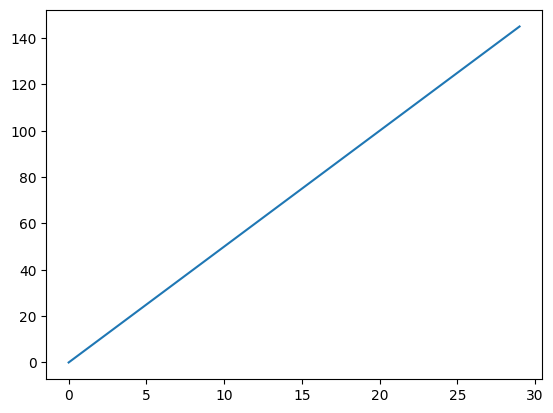

In [49]:
plt.plot(anim.history['t'])

In [161]:
plant.step([0.1])

dx = [1.0954e+17, 3.90618e+09, -6.96392e+19, 1.95316e+13]


array([ 5.47896079e+16,  1.95380316e+09, -3.48196007e+19,  9.76937238e+12])